In [3]:
data_path = '/data3/wangkun/phylovelo_datasets/elegans/'

In [4]:
import pyreadr
globalumap = pyreadr.read_r(data_path+'globalumap2d_Qin.rds')
globalumap = globalumap[None]

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import phylovelo as pv
import pickle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [168]:
plt.rcParams['font.size'] = 12

In [6]:
cell_annotation = pd.read_csv(data_path + 'GSE126954_cell_annotation.csv', index_col=0)

In [7]:
count_all = pd.read_csv(data_path+'Celegans_pass_qc_counts.csv', engine='c', low_memory=False)

In [8]:
count_all = count_all.T

In [54]:
vels_ab = pd.read_csv('../megs/celegans.csv', index_col=0)

## Pharynx

In [156]:
sel_cells = globalumap[(globalumap.V1<0.69)&(globalumap.V2>0.75)].index
sel_cells = np.random.choice(sel_cells, 2000, replace=False)
sel_cells = sel_cells[np.isin(sel_cells, cell_annotation.index)]

In [157]:
count = count_all.loc[sel_cells]
xdr = globalumap.loc[sel_cells]

In [158]:
sd = scData(count=count, Xdr=xdr)

In [168]:
sd = velocity_embedding(sd, target='count', n_neigh=200)

In [131]:
pv.calc_phylo_pseudotime(sd, r_sample=0.5)

  0%|          | 0/998 [00:00<?, ?it/s]

/tmp/ipykernel_137807/962770222.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


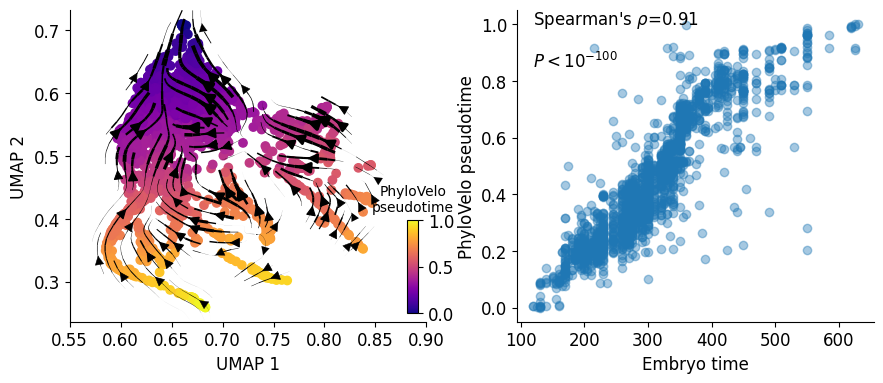

In [170]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

scatter = ax[0].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=sd.phylo_pseudotime, cmap='plasma')

ax[0] = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax[0], 'stream',streamdensity=1.2, grid_density=30, radius=0.015, lw_coef=200000, arrowsize=1.5)

ax[0].set_xlabel('UMAP 1', fontsize=12)
ax[0].set_ylabel('UMAP 2', fontsize=12)
cbaxes = inset_axes(ax[0], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.title('PhyloVelo\npseudotime',fontsize=10)
ax[0].set_xlim(0.55,0.9)

ax[1].scatter(cell_annotation.loc[sd.count.index]['embryo.time'], sd.phylo_pseudotime, alpha=0.4)
ax[1].set_xlabel('Embryo time')
ax[1].set_ylabel('PhyloVelo pseudotime')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
x, y = cell_annotation.loc[sd.count.index]['embryo.time'], sd.phylo_pseudotime
rho, pval = spearmanr(x, y)
ax[1].text(min(x)*1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=12)
if pval:
    ax[1].text(min(x)*1, max(y)*1-(max(y)-min(y))*0.15, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=12)
else:
    ax[1].text(min(x)*1, max(y)*1-(max(y)-min(y))*0.15, r'$P<10^{-100}$', fontsize=12)
plt.tight_layout()

In [45]:
global_umap_sel_ind = globalumap.index[np.isin(globalumap.index, cell_annotation.index)]

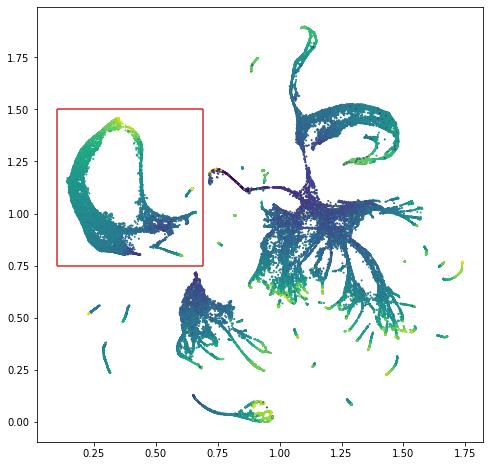

In [410]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(globalumap.V1[global_umap_sel_ind], globalumap.V2[global_umap_sel_ind], c=cell_annotation.loc[global_umap_sel_ind]['embryo.time'], s=1)
ax.hlines(0.75, 0.1, 0.69,colors='tab:red')
ax.hlines(1.5, 0.1, 0.69,colors='tab:red')
ax.vlines(0.1, 0.75, 1.5,colors='tab:red')
ax.vlines(0.69, 0.75, 1.5,colors='tab:red')
# ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c='tab:red', s=2, alpha=0.3)
# plt.savefig('./figures/C.elegans/globalumap_embryotime.pdf', dpi='figure', format='pdf')

## Hypodermis

In [171]:
sel_cells = globalumap[(globalumap.V2<1.9)&(globalumap.V2>1.3)&(globalumap.V1<1.5)&(globalumap.V1>0.95)&(~((globalumap.V1>1.3)&(globalumap.V1<1.42)&(globalumap.V2<1.4)))].index
sel_cells = np.random.choice(sel_cells, 2000, replace=False)
sel_cells = sel_cells[np.isin(sel_cells, cell_annotation.index)]

In [172]:
count = count_all.loc[sel_cells]
xdr = globalumap.loc[sel_cells]

In [173]:
sd = pv.scData(count=count, Xdr=xdr)
sd.drop_duplicate_genes(target='count')
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)
vels = []
for i in sd.count.columns:
    if i in vels_ab.index:
        vels.append(vels_ab['velocity'].loc[i])
    else:
        vels.append(0)
vels = np.array(vels)
sd.velocity = vels

In [181]:
pv.velocity_embedding(sd, target='count', n_neigh=200)

  0%|          | 0/1999 [00:00<?, ?it/s]

In [182]:
pv.calc_phylo_pseudotime(sd, r_sample=0.5)

  0%|          | 0/998 [00:00<?, ?it/s]

/tmp/ipykernel_137807/583806489.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


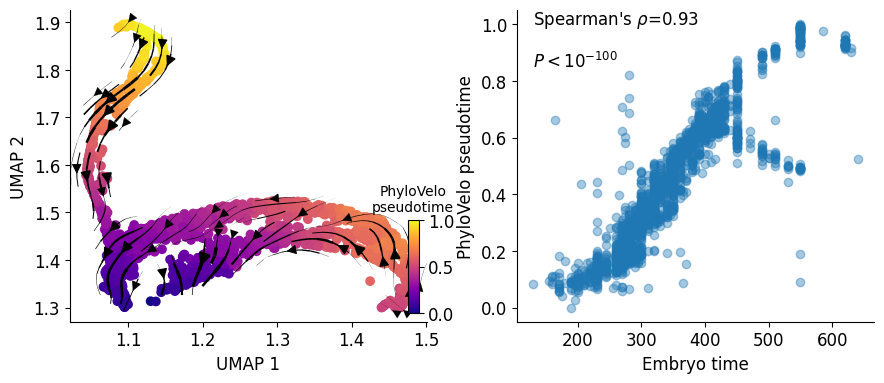

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

scatter = ax[0].scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=sd.phylo_pseudotime, cmap='plasma')

ax[0] = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax[0], 'stream',streamdensity=1.2, grid_density=30, radius=0.015, lw_coef=200000, arrowsize=1.5)

ax[0].set_xlabel('UMAP 1', fontsize=12)
ax[0].set_ylabel('UMAP 2', fontsize=12)
cbaxes = inset_axes(ax[0], width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.title('PhyloVelo\npseudotime',fontsize=10)
# ax[0].set_xlim(0.55,0.9)

ax[1].scatter(cell_annotation.loc[sd.count.index]['embryo.time'], sd.phylo_pseudotime, alpha=0.4)
ax[1].set_xlabel('Embryo time')
ax[1].set_ylabel('PhyloVelo pseudotime')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
x, y = cell_annotation.loc[sd.count.index]['embryo.time'], sd.phylo_pseudotime
rho, pval = spearmanr(x, y)
ax[1].text(min(x)*1, max(y), r"Spearman's $\rho$={:.2g}".format(rho), fontsize=12)
if pval:
    ax[1].text(min(x)*1, max(y)*1-(max(y)-min(y))*0.15, r'$P={}\times 10^{}$'.format(*r'{:.2g}'.format(pval).split('e')).replace('^', '^{').replace('$', '}$')[1:], fontsize=12)
else:
    ax[1].text(min(x)*1, max(y)*1-(max(y)-min(y))*0.15, r'$P<10^{-100}$', fontsize=12)
plt.tight_layout()

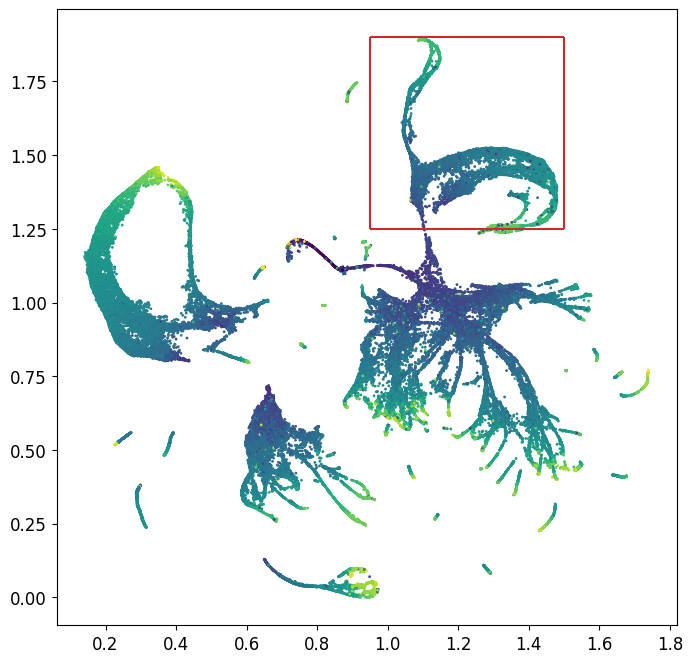

In [185]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(globalumap.V1[global_umap_sel_ind], globalumap.V2[global_umap_sel_ind], c=cell_annotation.loc[global_umap_sel_ind]['embryo.time'], s=1)
ax.vlines(0.95, 1.25, 1.9,colors='tab:red')
ax.vlines(1.5, 1.25, 1.9,colors='tab:red')
ax.hlines(1.25, 0.95, 1.5,colors='tab:red')
ax.hlines(1.9, 0.95, 1.5,colors='tab:red')
# ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c='tab:red', s=2, alpha=0.3)
# plt.savefig('./figures/C.elegans/globalumap_embryotime.pdf', dpi='figure', format='pdf')

## Body wall muscle

In [156]:
sel_cells = globalumap[(globalumap.V1<0.69)&(globalumap.V2>0.75)].index
sel_cells = np.random.choice(sel_cells, 2000, replace=False)
sel_cells = sel_cells[np.isin(sel_cells, cell_annotation.index)]

In [157]:
count = count_all.loc[sel_cells]
xdr = globalumap.loc[sel_cells]

In [158]:
sd = scData(count=count, Xdr=xdr)

In [ ]:
sd = pv.scData(count=count, Xdr=xdr)
sd.drop_duplicate_genes(target='count')
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)
vels = []
for i in sd.count.columns:
    if i in vels_ab.index:
        vels.append(vels_ab['velocity'].loc[i])
    else:
        vels.append(0)
vels = np.array(vels)
sd.velocity = vels

In [181]:
pv.velocity_embedding(sd, target='count', n_neigh=200)

  0%|          | 0/1999 [00:00<?, ?it/s]

In [182]:
pv.calc_phylo_pseudotime(sd, r_sample=0.5)

  0%|          | 0/998 [00:00<?, ?it/s]

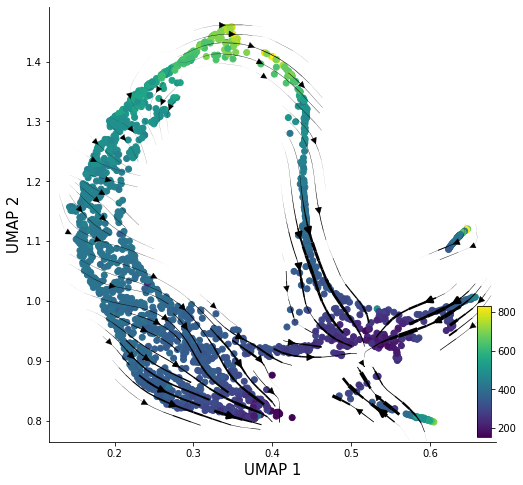

In [352]:
fig, ax = plt.subplots()

scatter = ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c=cell_annotation.loc[sd.count.index]['embryo.time'])

ax = velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, grid_density=30, radius=0.02, lw_coef=100000, arrowsize=1.5)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

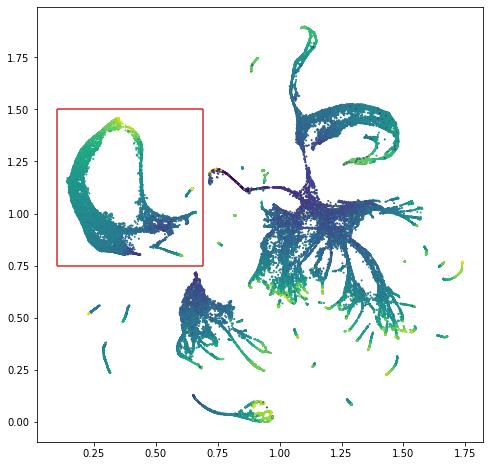

In [410]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(globalumap.V1[global_umap_sel_ind], globalumap.V2[global_umap_sel_ind], c=cell_annotation.loc[global_umap_sel_ind]['embryo.time'], s=1)
ax.hlines(0.75, 0.1, 0.69,colors='tab:red')
ax.hlines(1.5, 0.1, 0.69,colors='tab:red')
ax.vlines(0.1, 0.75, 1.5,colors='tab:red')
ax.vlines(0.69, 0.75, 1.5,colors='tab:red')
# ax.scatter(sd.Xdr.iloc[:, 0], sd.Xdr.iloc[:, 1], c='tab:red', s=2, alpha=0.3)
# plt.savefig('./figures/C.elegans/globalumap_embryotime.pdf', dpi='figure', format='pdf')